# Analyze runs

Small notebook to show how to read the runs and fetch their data/analyze the result

In [9]:
# # On CIT, you need to load the following modules, otherwise the script breaks
# import psutil
# p = psutil.Process()
# p.cpu_affinity([0])

import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import numpy as np
import matplotlib.pyplot as plt
# import corner
import json

from bilby.gw.conversion import chirp_mass_and_mass_ratio_to_component_masses

# Matplotlib and corner settings:
params = {"axes.grid": True,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}

plt.rcParams.update(params)

# Improved corner kwargs
default_corner_kwargs = dict(bins=40, 
                        smooth=1., 
                        show_titles=False,
                        label_kwargs=dict(fontsize=16),
                        title_kwargs=dict(fontsize=16), 
                        color="blue",
                        # quantiles=[],
                        # levels=[0.9],
                        plot_density=True, 
                        plot_datapoints=False, 
                        fill_contours=True,
                        max_n_ticks=4, 
                        min_n_ticks=3,
                        save=False)

## Runs location

The runs are saved on CIT in the following `outdir`. Each subdirectory is a separate injection, and has an identifier that is the `simulation_id` as outputted from Weizmann's runs. 
The final posterior samples are saved in `results_production.npz` in each subdirectory.

In [5]:
outdir = "/home/thibeau.wouters/projects/jim_H0/injections_tidal/outdir/" # on CIT

run_dirs = os.listdir(outdir)
run_dirs = [outdir + run_dir + "/" for run_dir in run_dirs]
example_dir = run_dirs[0]

# Show example
print(f"Example subdir: {example_dir}")
print(f"There are {len(run_dirs)} runs")

# Sometimes, the run might be incomplete, so we need to check if the file results_production.npz exists:
for d in run_dirs:
    file = d + "results_production.npz"
    if not os.path.isfile(file):
        print(f"File {file} does not exist -- this run was aborted")

Example subdir: /home/thibeau.wouters/projects/jim_H0/injections_tidal/outdir/injection_3912/
There are 36 runs
File /home/thibeau.wouters/projects/jim_H0/injections_tidal/outdir/injection_737/results_production.npz does not exist -- this run was aborted


The naming/order of the parameters are as follows (for more information regarding definition of parameters see Table 2 of [our paper](https://arxiv.org/abs/2404.11397) -- the ranges of parameters are different here though)

In [6]:
NAMING = ['M_c', 'q', 's1_z', 's2_z', 'lambda_1', 'lambda_2', 'd_L', 't_c', 'phase_c', 'cos_iota', 'psi', 'ra', 'sin_dec']
NAMING_no_lambda = ['M_c', 'q', 's1_z', 's2_z', 'd_L', 't_c', 'phase_c', 'cos_iota', 'psi', 'ra', 'sin_dec'] # needed below when loading/plotting

## Injected parameters

In each subdirectory, the injected parameters are saved in `config.json`, and they can be loaded as follows:

In [10]:
def load_true_params_from_config(outdir, convert_masses: bool = True):
    """
    Load the true parameters from the config file. This function also converts Mc and eta to m1 and m2 if desired.     

    Args:
        outdir (str): Outdir where the run is located
        convert_masses (bool, optional): Whether to convert Mc and q to m1 and m2. Defaults to True.

    Returns:
        np.array: The injected parameters as an array. See naming no lambdas for details.
    """
    
    config = outdir + 'config.json'
    # Load the config   
    with open(config) as f:
        config = json.load(f)
        
    if convert_masses:
        true_params = np.array([config[key] for key in NAMING_no_lambda])
        mc, q = true_params[0], true_params[1]
        m1, m2 = chirp_mass_and_mass_ratio_to_component_masses(mc, q)
        
        true_params[0] = m1
        true_params[1] = m2
    
    ## TODO: get masses if desired?
    # m1, m2 = Mc_eta_to_ms(np.array([mc, eta]))
    # lambda1, lambda2 = get_lambda(m1), get_lambda(m2)
    
    # true_params = np.insert(true_params, 4, lambda1)
    # true_params = np.insert(true_params, 5, lambda2)
    
    # Convert cos_iota and sin_dec to iota and dec
    cos_iota_index = NAMING_no_lambda.index('cos_iota')
    sin_dec_index = NAMING_no_lambda.index('sin_dec')
    true_params[cos_iota_index] = np.arccos(true_params[cos_iota_index])
    true_params[sin_dec_index] = np.arcsin(true_params[sin_dec_index])
    
    return true_params

We load a single file with the results of the injection: ignore log prob, local accs, and global accs: these are to diagnoze the sampler. The chains have shape `(n_chains, n_steps, n_dim)`.

In [15]:
example_file = np.load(example_dir + "results_production.npz")
print(f"Contents of example file: {example_file}")

chains = example_file['chains']
print(f"Shape of chains: {chains.shape}")

example_params = load_true_params_from_config(example_dir, convert_masses=True)
print(f"Example of injected params: ")

for i, (key, value) in enumerate(zip(NAMING_no_lambda, example_params)):
    if i == 0:
        key = "m1"
    if i == 1:
        key = "m2"
    print(f"{key}: {example_params[i]}")

Contents of example file: NpzFile '/home/thibeau.wouters/projects/jim_H0/injections_tidal/outdir/injection_3912/results_production.npz' with keys: chains, log_prob, local_accs, global_accs
Shape of chains: (1000, 760, 13)
Example of injected params: 
m1: 1.852844181348028
m2: 1.5420775974655332
s1_z: -0.04327765
s2_z: -0.035384854
d_L: 584.16877
t_c: 0.0
phase_c: -3.051407814025879
cos_iota: 0.59487178
psi: 5.933746814727783
ra: 2.9573194
sin_dec: 0.5458782699999999


## dL histogram

In [18]:
def get_injection_values(rundir_list: str, key: str = "d_L") -> np.array:
    # Iterate over all rundirs, fetch the dL from the config.json
    dL_list = []
    
    for d in rundir_list:
        config = d + 'config.json'
        # Load the config   
        with open(config) as f:
            config = json.load(f)
            
        dL_list.append(config[key])
        
    return np.array(dL_list)

Example

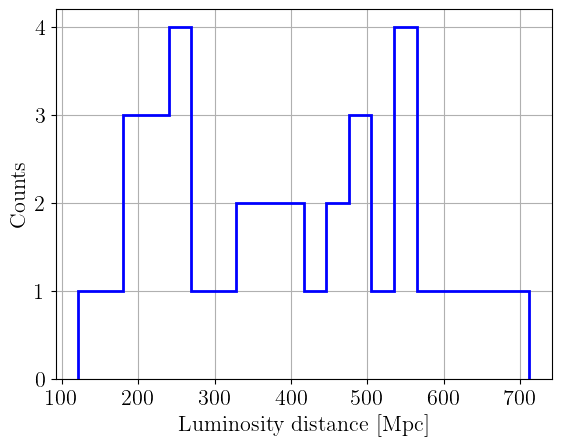

In [20]:
dL_list = get_injection_values(run_dirs, key="d_L")
plt.hist(dL_list, bins=20, color = "blue", linewidth=2, histtype='step')
plt.xlabel("Luminosity distance [Mpc]")
plt.ylabel("Counts")
plt.show()

## SNR

Note: the SNR is slightly different from Weizmann since we used a different waveform. Also, the network SNR depends on how many detectors were "operational" in the event etc. Note that it is saved separately

In [22]:
def get_injection_snr(rundir_list: str) -> np.array:
    # Iterate over all rundirs, fetch the dL from the config.json
    snr_list = []
    
    for d in rundir_list:
        file = d + 'network_snr.txt'
        snr = np.loadtxt(file)
        snr_list.append(snr)
        
    return np.array(snr_list)

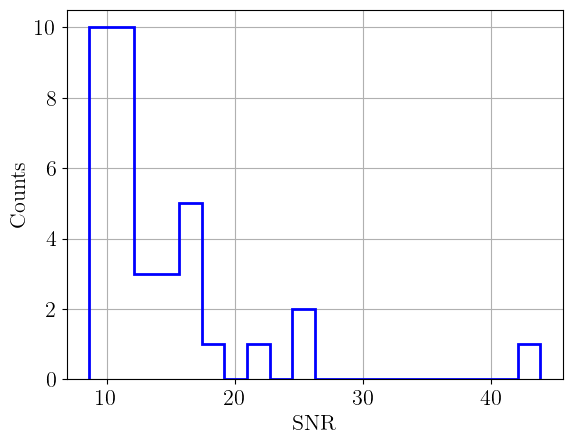

In [23]:
snr_list = get_injection_snr(run_dirs)
plt.hist(snr_list, bins=20, color = "blue", linewidth=2, histtype='step')
plt.xlabel("SNR")
plt.ylabel("Counts")
plt.show()

It seems there is one outlier with a very high SNR -- this might severely impact the results in terms of ordering the different runs!

## Histograms for dL for a run

In [28]:
def get_dL_posterior(rundir: str) -> np.array:
    """
    Load the posterior distribution of only dL for a specific rundir.

    Args:
        rundir (str): The outdir of a specific single run

    Returns:
        np.array: The array of posterior samples of dL.
    """
    
    posterior_file = np.load(rundir + "results_production.npz")
    chains = posterior_file['chains']
    chains = np.reshape(chains, (-1, len(NAMING)))
    dL_index = NAMING.index('d_L')
    dL = chains[:, dL_index]
    
    return dL

Example

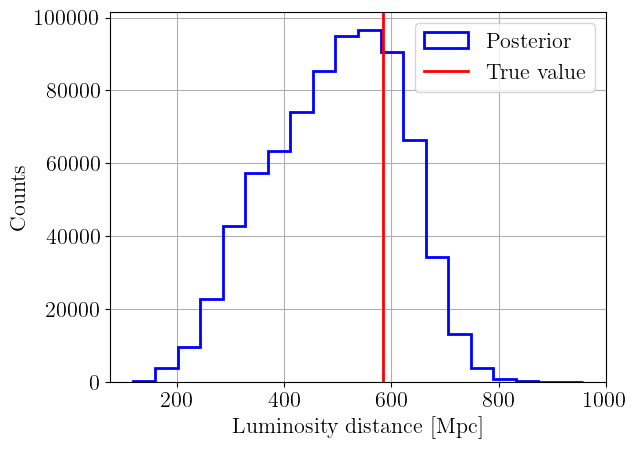

In [33]:
dL = get_dL_posterior(example_dir)

# Get the true value for this dL:
true_dL = load_true_params_from_config(example_dir, convert_masses=True)[4]

plt.hist(dL, bins=20, color = "blue", linewidth=2, histtype='step', label = "Posterior")
plt.axvline(true_dL, color = "red", linewidth=2, label = "True value")
plt.xlabel("Luminosity distance [Mpc]")
plt.ylabel("Counts")
plt.legend()
plt.show()

## Full posterior cornerplots

You can find them here: https://github.com/ThibeauWouters/jim_H0/tree/tidal/injections_tidal/outdir

For each subdirectory, have a look at `chains_production.png` to see how the recovery went.